# Problem Set 2

### CSCI 5352

### Ben Braun

In [2]:
# Mean degree of each network + histogram

import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd

# # Path to the dataset directory
# path = r'C:\Users\benja\Downloads\facebook100txt\facebook100txt'

# # Don't read metadata files
# ignore = ['.DS_Store','facebook100_readme_021011.txt','facebook100_readme_aaron.txt','Traud_Mucha_Porter_2012_SocialStructureOfFacebookNetworks.pdf']

# # Get a list of file for the edgelists and attribute files
# edgelist_files = [f for f in glob.glob(os.path.join(path, '*.txt')) if os.path.basename(f) not in ignore and not f.endswith('_attr.txt')]
# # attribute_files = [f for f in glob.glob(os.path.join(path, '*_attr.txt')) if os.path.basename(f) not in ignore]

In [2]:
def read_edgelist(file):
	# make an adjacency list
	adjacency_list = {}
	current_node = 1
	current_adjacencies = []
	with open(file) as f:
		while True:
			# split the line by whitespace
			edge = f.readline().split()
			# if we've reached the end of the file, we break out of the loop
			if not edge:
				adjacency_list[current_node] = current_adjacencies
				break
			# the files are sorted by the second node, so we can build up each node's list before appending it to the full adjacency list
			# this helps avoid excessive read/writes to the large data structures
			if int(edge[1]) == current_node:
				current_adjacencies.append(int(edge[0]))
			else:
				# now we're at the next node, so we append the completed adjacency list for the previous node to the full adjacency list
				adjacency_list[current_node] = current_adjacencies
				# then we reset the current node and adjacency list and start building up the next node's list
				current_node = int(edge[1])
				current_adjacencies = [int(edge[0])]
	
	return adjacency_list

In [3]:
berkeley = read_edgelist('/Users/bebr1814/projects/networks_hw/Berkeley13.txt')

In [4]:
import numpy as np
from collections import deque, defaultdict
from tqdm import tqdm
import igraph
import random


def clustering_coefficient(adj):
    # Calculate the clustering coefficient for a node
    def node_clustering_coefficient(node):
        neighbors = set(adj[node])  # Use a set to avoid duplicates
        if len(neighbors) < 2:
            return 0
        edges = 0
        for neighbor in neighbors:
            # Only count edges between neighbors
            edges += len(neighbors.intersection(adj[neighbor]))
        edges /= 2  # Each edge is counted twice, so divide by 2
        return edges / (len(neighbors) * (len(neighbors) - 1))

    # Calculate the average clustering coefficient for all nodes
    total = sum(node_clustering_coefficient(node) for node in adj)
    return total / len(adj)

def mean_path_length(adj):
    # convert to igraph
    g = igraph.Graph.TupleList([(node, neighbor) for node in adj for neighbor in adj[node] if node < neighbor])
    components = g.components()
    largest_component = components.giant()
    return largest_component.average_path_length(directed=False)

def double_edge_swap(adj, num_swaps):
    """
    Perform double edge swaps while maintaining graph connectivity.
    Uses an efficient edge list representation for sampling.
    
    Parameters:
    adj (dict): Adjacency list representation of the graph
    num_swaps (int): Number of successful swaps to perform
    
    Returns:
    dict: Updated adjacency list
    """
    # Create edge list for efficient sampling
    edges = []
    for node in adj:
        for neighbor in adj[node]:
            if node < neighbor:  # Add each edge only once
                edges.append((node, neighbor))
    
    successful_swaps = 0
    attempts = 0
    max_attempts = num_swaps * 10  # Limit total attempts to avoid infinite loops
    
    while successful_swaps < num_swaps and attempts < max_attempts:
        # Randomly select two edges
        i1, i2 = random.sample(range(len(edges)), 2)
        edge1, edge2 = edges[i1], edges[i2]
        
        # Extract endpoints
        a, b = edge1
        c, d = edge2
        
        # Skip if edges share vertices
        if len({a, b, c, d}) < 4:
            attempts += 1
            continue
        
        # Randomly choose swap configuration
        if random.random() < 0.5:
            new_edge1, new_edge2 = (a, c), (b, d)
        else:
            new_edge1, new_edge2 = (a, d), (b, c)
        
        # Check if new edges already exist
        if (new_edge1[0] in adj[new_edge1[1]] or 
            new_edge2[0] in adj[new_edge2[1]]):
            attempts += 1
            continue
        
        # Perform the swap
        # Remove old edges
        adj[a].remove(b)
        adj[b].remove(a)
        adj[c].remove(d)
        adj[d].remove(c)
        
        # Add new edges
        n1, n2 = new_edge1
        n3, n4 = new_edge2
        adj[n1].append(n2)
        adj[n2].append(n1)
        adj[n3].append(n4)
        adj[n4].append(n3)
        
        # Update edge list
        edges[i1] = tuple(sorted(new_edge1))
        edges[i2] = tuple(sorted(new_edge2))
        
        successful_swaps += 1
        attempts += 1
    
    return adj

def analyze_network_rewiring(adj_dict, num_samples=20):
    """
    Analyze network properties during rewiring process.
    
    Parameters:
    adj_dict (dict): Adjacency list dictionary
    num_samples (int): Number of sampling points
    
    Returns:
    dict: Results of the analysis
    """
    # Make a deep copy of the adjacency list
    adj = {k: list(v) for k, v in adj_dict.items()}
    
    # Calculate initial metrics
    initial_clustering = clustering_coefficient(adj)
    initial_path_length = mean_path_length(adj)
    
    print("\nInitial network metrics:")
    print(f"Clustering coefficient: {initial_clustering:.4f}")
    print(f"Mean path length: {initial_path_length:.4f}")
    
    # Calculate total number of edges
    num_edges = sum(len(neighbors) for neighbors in adj.values()) // 2
    total_swaps = 20 * num_edges
    
    # Generate logarithmically spaced sampling points
    sample_points = np.logspace(0, np.log10(total_swaps), num_samples, dtype=int)
    
    results = {
        'steps': [],
        'clustering': [],
        'path_length': []
    }
    
    print("\nSampling points and metrics:")
    print("-" * 60)
    print(f"{'Step':>12} | {'Swaps':>12} | {'Clustering':>12} | {'Path Length':>12}")
    print("-" * 60)
    
    swaps_performed = 0
    for i, target_swaps in enumerate(tqdm(sample_points, desc="Rewiring progress")):
        # Perform necessary number of swaps to reach target
        swaps_to_do = target_swaps - swaps_performed
        adj = double_edge_swap(adj, swaps_to_do)
        
        # Calculate metrics
        clustering = clustering_coefficient(adj)
        path_length = mean_path_length(adj)
        
        results['steps'].append(target_swaps)
        results['clustering'].append(clustering)
        results['path_length'].append(path_length)
        
        print(f"{i+1:>12d} | {target_swaps:>12d} | {clustering:>12.4f} | {path_length:>12.4f}")
        
        swaps_performed = target_swaps
    
    print("-" * 60)
    
    # Add initial values to results
    results['initial_clustering'] = initial_clustering
    results['initial_path_length'] = initial_path_length
    
    return results

In [40]:
# print number of edges
num_edges = sum(len(neighbors) for neighbors in berkeley.values()) // 2
num_edges

852444

In [43]:
import networkx
# Create a NetworkX graph from the adjacency list
G = networkx.Graph(berkeley)
networkx.transitivity(G)

0.11381994864532341

In [44]:
networkx.average_clustering(G)

0.20698964106006912

In [37]:
g = igraph.Graph.TupleList([(node, neighbor) for node in berkeley for neighbor in berkeley[node] if node < neighbor])
g.transitivity_undirected()

0.11381994864532341

In [38]:
clustering_coefficient(berkeley)

0.10349482053003456

In [19]:
results = analyze_network_rewiring(berkeley,num_samples=5)


Initial network metrics:
Clustering coefficient: 0.1035
Mean path length: 2.9399

Sampling points and metrics:
------------------------------------------------------------
        Step |        Swaps |   Clustering |  Path Length
------------------------------------------------------------


Rewiring progress:  20%|██        | 1/5 [02:04<08:19, 124.82s/it]

           1 |            1 |       0.1035 |       2.9399


Rewiring progress:  40%|████      | 2/5 [04:02<06:02, 120.77s/it]

           2 |           64 |       0.1034 |       2.9397


Rewiring progress:  60%|██████    | 3/5 [06:04<04:02, 121.12s/it]

           3 |         4129 |       0.1008 |       2.9326


Rewiring progress:  80%|████████  | 4/5 [08:19<02:06, 126.59s/it]

           4 |       265321 |       0.0217 |       2.8021


Rewiring progress: 100%|██████████| 5/5 [17:35<00:00, 211.17s/it]

           5 |     17048879 |       0.0077 |       2.7579
------------------------------------------------------------


In [20]:
# convert results to dataframe
df = pd.DataFrame(results)
df.to_csv('problem_3_results.csv', index=False)
df

,steps,clustering,path_length,initial_clustering,initial_path_length
0,1,0.103488,2.939890,0.103495,2.939906
1,64,0.103446,2.939747,0.103495,2.939906
2,4129,0.100769,2.932634,0.103495,2.939906
3,265321,0.021672,2.802133,0.103495,2.939906
4,17048879,0.007742,2.757915,0.103495,2.939906


In [6]:
df = pd.read_csv('/Users/bebr1814/projects/networks_hw/problem_3_results.csv')

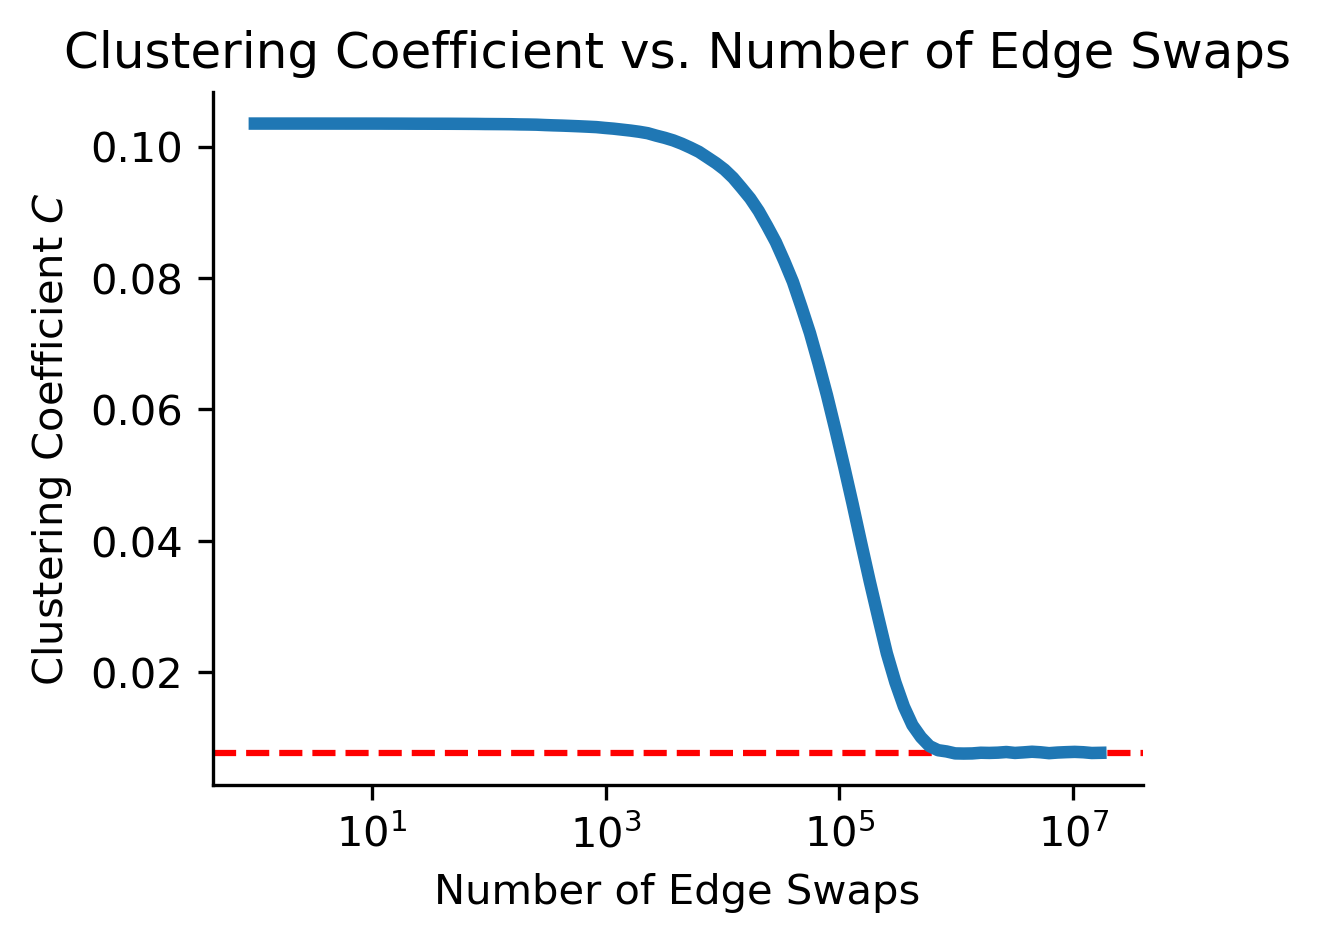

In [11]:
# Plot the clustering coefficient against the number of swaps
# x-axis is swaps (log) and y-axis is CC
# Add a horizontal line at the final CC value
fig, ax = plt.subplots(figsize=(4,3), dpi=300)

sns.lineplot(data=df, x='steps', y='clustering', ax=ax, linewidth=3)
ax.axhline(df['clustering'].iloc[-1], color='red', linestyle='--', label=r'Configuration $C$',zorder=0)
ax.set_xscale('log')
ax.set_xlabel('Number of Edge Swaps')
ax.set_ylabel(r'Clustering Coefficient $C$')
ax.set_title('Clustering Coefficient vs. Number of Edge Swaps')
sns.despine()
# ax.legend()
plt.show()


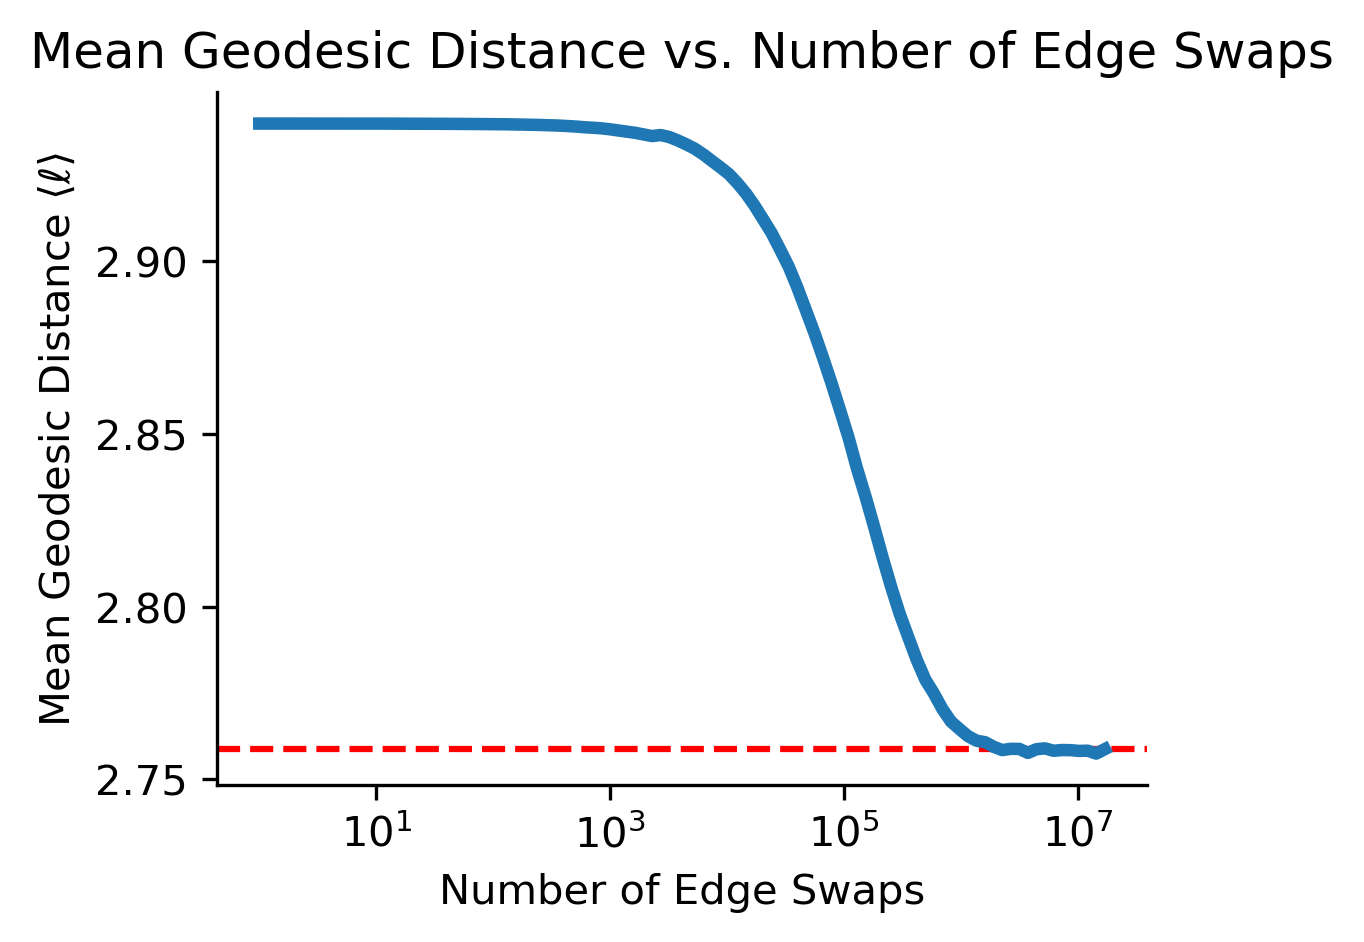

In [10]:
# Plot the mean geodesic distance against the number of swaps
# x-axis is swaps (log) and y-axis is mean geodesic distance
# Add a horizontal line at the final mean geodesic distance value
fig, ax = plt.subplots(figsize=(4,3), dpi=300)

sns.lineplot(data=df, x='steps', y='path_length', ax=ax, linewidth=3)
ax.axhline(df['path_length'].iloc[-1], color='red', linestyle='--', label=r'Configuration $\langle \ell \rangle$',zorder=0)
ax.set_xscale('log')
ax.set_xlabel('Number of Edge Swaps')
ax.set_ylabel(r'Mean Geodesic Distance $\langle \ell \rangle$')
ax.set_title('Mean Geodesic Distance vs. Number of Edge Swaps')
sns.despine()
plt.show()


### Problem 4

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy
from matplotlib.lines import Line2D

# set matplotlib params for pdf output
plt.rcParams['pdf.fonttype'] = 42

def analyze_degrees(adj):
    """
    Efficiently analyze degree structure of a graph.
    
    Parameters:
    adj (dict): Adjacency list representation of graph
    
    Returns:
    tuple: (degree_sequence, degree_counts, min_degree, max_degree, mean_degree)
           where degree_counts is a dict mapping degrees to their frequencies
    """
    # Get degrees for all nodes
    degrees = [len(neighbors) for neighbors in adj.values()]
    
    # Create degree distribution
    degree_counts = {}
    for d in degrees:
        degree_counts[d] = degree_counts.get(d, 0) + 1
    
    # Calculate summary statistics
    min_degree = min(degrees)
    max_degree = max(degrees)
    mean_degree = sum(degrees) / len(degrees)
    
    return (
        sorted(degrees, reverse=True),  # degree sequence
        degree_counts,                  # degree distribution
        min_degree,
        max_degree,
        mean_degree
    )

def generate_null_distribution(adj, n_samples=1000):
	"""
	Generate null distributions for clustering and path length under configuration model.
	
	Parameters:
	adj (dict): Original adjacency list
	n_samples (int): Number of random rewired networks to generate
	
	Returns:
	tuple: (clustering_samples, path_length_samples)
	"""
	# Calculate number of edges for rewiring
	num_edges = sum(len(neighbors) for neighbors in adj.values()) // 2
	
	# Store metrics for each sample
	clustering_samples = []
	path_length_samples = []
	
	# Get original metrics for comparison
	original_clustering = clustering_coefficient(adj)
	original_path_length = mean_path_length(adj)
	
	# Generate samples
	for _ in tqdm(range(n_samples), desc="Generating null distribution"):
		# Make a deep copy of original graph
		adj_copy = {k: list(v) for k, v in adj.items()}
		
		# Perform full randomization (20m swaps)
		adj_copy = double_edge_swap(adj_copy, 20 * num_edges)
		
		# Calculate and store metrics
		c = clustering_coefficient(adj_copy)
		pl = mean_path_length(adj_copy)
		
		clustering_samples.append(c)
		path_length_samples.append(pl)
	
	return (
		clustering_samples, 
		path_length_samples, 
		original_clustering, 
		original_path_length
	)

def plot_null_distributions(clustering_samples, path_length_samples, 
						  original_clustering, original_path_length,label):
	"""
	Plot null distributions with empirical values as vertical lines.
	"""
	fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
	
	# Plot clustering coefficient distribution
	sns.histplot(clustering_samples, bins=20, kde=True, color='skyblue', edgecolor='black', ax=ax1)
	ax1.axvline(original_clustering, color='red', linestyle='--', linewidth=2)
	ax1.set_title('Clustering Coefficient Distribution')
	ax1.set_xlabel('Clustering Coefficient')
	ax1.set_ylabel('Density')
	
	# Add mean and std dev to clustering plot
	mean_c = np.mean(clustering_samples)
	std_c = np.std(clustering_samples)
	z_score_c = (original_clustering - mean_c) / std_c
	# ax1.text(0.05, 0.95, f'z-score: {z_score_c:.2f}\nμ: {mean_c:.3f}\nσ: {std_c:.3f}', 
	# 		 transform=ax1.transAxes, verticalalignment='top',
	# 		 bbox=dict(facecolor='white', alpha=0.8))
	# Add custom legend that indicates null dist, empirical value, and z-score
	legend_handles = [
		Line2D([0], [0], color='red', linestyle='--', label='Empirical Value'),
		Line2D([0], [0], color='skyblue', label='Null Distribution'),
		Line2D([0], [0], color='none', label=f'Z-score: {z_score_c:.2f}')
	]
	ax1.legend(handles=legend_handles, loc='upper center', frameon=False)

	sns.despine()

	# Plot path length distribution
	sns.histplot(path_length_samples, bins=20, kde=True, color='lightgreen', edgecolor='black', ax=ax2)
	ax2.axvline(original_path_length, color='red', linestyle='--', linewidth=2)
	ax2.set_title('Mean Path Length Distribution')
	ax2.set_xlabel('Mean Path Length')
	ax2.set_ylabel('Density')
	
	# Add mean and std dev to path length plot
	mean_pl = np.mean(path_length_samples)
	std_pl = np.std(path_length_samples)
	z_score_pl = (original_path_length - mean_pl) / std_pl
	# ax2.text(0.05, 0.95, f'z-score: {z_score_pl:.2f}\nμ: {mean_pl:.3f}\nσ: {std_pl:.3f}', 
	# 		 transform=ax2.transAxes, verticalalignment='top',
	# 		 bbox=dict(facecolor='white', alpha=0.8))
		# Add custom legend that indicates null dist, empirical value, and z-score
	legend_handles = [
		Line2D([0], [0], color='red', linestyle='--', label='Empirical Value'),
		Line2D([0], [0], color='lightgreen', label='Null Distribution'),
		Line2D([0], [0], color='none', label=f'Z-score: {z_score_pl:.2f}')
	]
	ax2.legend(handles=legend_handles, loc='upper center', frameon=False)

	sns.despine()
	
	plt.tight_layout()

	plt.savefig(f'null_distributions.{label}.png', dpi=300, bbox_inches='tight')
	plt.savefig(f'null_distributions.{label}.pdf', dpi=300, bbox_inches='tight')

	return fig, (ax1, ax2)

def compare_to_configuration_model(adj, label, n_samples=100):
	"""
	Compare input graph to configuration model null distribution.
	
	Parameters:
	adj (dict): Adjacency list of input graph
	n_samples (int): Number of random rewired networks to generate
	
	Returns:
	tuple: (figure, (ax1, ax2))
	"""
	# Generate null distributions
	(clustering_samples, path_length_samples, 
	 original_clustering, original_path_length) = generate_null_distribution(adj, n_samples)

	# write to file
	with open(f'clustering_samples.{label}.txt', 'w') as f:
		for c in clustering_samples:
			f.write(f'{c}\n')
	
	with open(f'path_length_samples.{label}.txt', 'w') as f:
		for pl in path_length_samples:
			f.write(f'{pl}\n')
	
	# Create visualization
	return plot_null_distributions(clustering_samples, path_length_samples, 
								 original_clustering, original_path_length,label)



In [14]:
# Social network
social_network = {}
with open('/Users/bebr1814/projects/networks_hw/slavko.net') as f:
	f.readline()
	f.readline()
	for line in f.readlines():
		source, target = line.split()[:2]
		source = int(source)
		target = int(target)
		if source not in social_network:
			social_network[source] = [target]
		social_network[source].append(target)

		if target not in social_network:
			social_network[target] = [source]
		social_network[target].append(source)
		

# deduplicate with sets
for key in social_network:
	social_network[key] = list(set(social_network[key]))


# Food web
food_web = {}
with open('/Users/bebr1814/projects/networks_hw/out.maayan-foodweb') as f:
	f.readline()
	for line in f.readlines():
		source, target = line.split()[:2]
		source = int(source)
		target = int(target)
		if source not in food_web:
			food_web[source] = [target]
		food_web[source].append(target)

		if target not in food_web:
			food_web[target] = [source]
		food_web[target].append(source)


# deduplicate with sets
for key in food_web:
	food_web[key] = list(set(food_web[key]))


# Connectome
connectome = {}
with open('/Users/bebr1814/projects/networks_hw/mixed.species_brain_1.graphml') as f:
	for line in f.readlines():
		if 'source=' in line:
			source = int(line.split('source="')[1].split('"')[0].replace('n',''))
		if 'target=' in line:
			target = int(line.split('target="')[1].split('"')[0].replace('n',''))
			if source not in connectome:
				connectome[source] = [target]
			connectome[source].append(target)

			if target not in connectome:
				connectome[target] = [source]
			connectome[target].append(source)

# deduplicate with sets
for key in connectome:
	connectome[key] = list(set(connectome[key]))



Generating null distribution:   0%|          | 1/1000 [00:00<08:25,  1.97it/s]

Generating null distribution: 100%|██████████| 1000/1000 [08:30<00:00,  1.96it/s]


(<Figure size 800x300 with 2 Axes>,
 (<Axes: title={'center': 'Clustering Coefficient Distribution'}, xlabel='Clustering Coefficient', ylabel='Density'>,
  <Axes: title={'center': 'Mean Path Length Distribution'}, xlabel='Mean Path Length', ylabel='Density'>))

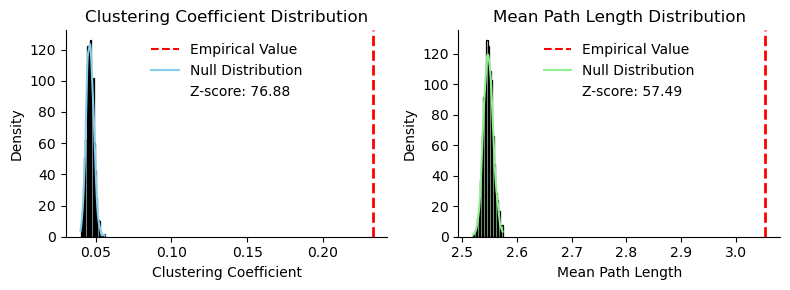

In [20]:
compare_to_configuration_model(social_network, 'social_network', n_samples=1000)

Generating null distribution: 100%|██████████| 1000/1000 [16:28<00:00,  1.01it/s]


(<Figure size 800x300 with 2 Axes>,
 (<Axes: title={'center': 'Clustering Coefficient Distribution'}, xlabel='Clustering Coefficient', ylabel='Density'>,
  <Axes: title={'center': 'Mean Path Length Distribution'}, xlabel='Mean Path Length', ylabel='Density'>))

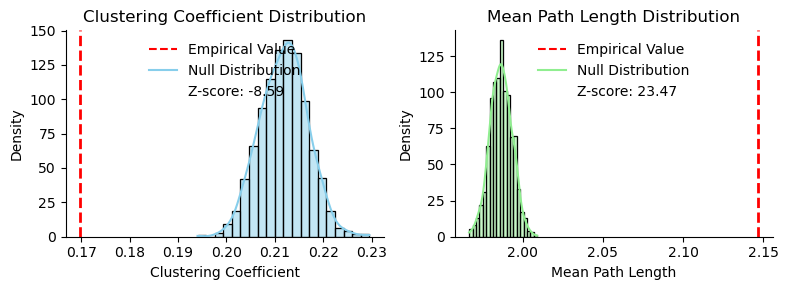

In [21]:
compare_to_configuration_model(food_web, 'food_web', n_samples=1000)

Generating null distribution: 100%|██████████| 1000/1000 [07:01<00:00,  2.37it/s]


(<Figure size 800x300 with 2 Axes>,
 (<Axes: title={'center': 'Clustering Coefficient Distribution'}, xlabel='Clustering Coefficient', ylabel='Density'>,
  <Axes: title={'center': 'Mean Path Length Distribution'}, xlabel='Mean Path Length', ylabel='Density'>))

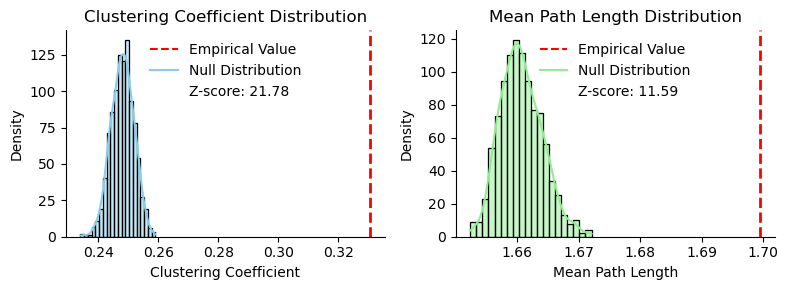

In [19]:
compare_to_configuration_model(connectome, 'connectome', n_samples=1000)

### Problem 5

In [6]:
import re

medici = {}
names = {}
with open('/Users/bebr1814/projects/networks_hw/medici_network.txt') as f:
    
	for line in f:
		parts = re.match(r'(\d+)\s[\w]+,\s\d+\s\d+\s\[([^\]]*)\]', line)
		if parts:
			node = int(parts.group(1))
			edges = re.findall(r'\((\d+),\s(\d+)\)', parts.group(2))
			medici[node] = [int(dest) for dest, _ in edges]
			names[node] = re.match(r'\d+\s([\w]+),\s\d+\s\d+\s\[([^\]]*)\]', line).group(1)


print(names)
print(medici)

# make a version of the adjacency list with names instead of numbers
medici_names = {}
for node in medici:
	medici_names[names[node]] = [names[dest] for dest in medici[node]]
medici_names

{0: 'Acciaiuoli', 1: 'Albizzi', 2: 'Barbadori', 3: 'Bischeri', 4: 'Castellani', 5: 'Ginori', 6: 'Guadagni', 7: 'Lamberteschi', 8: 'Medici', 9: 'Pazzi', 10: 'Peruzzi', 11: 'Pucci', 12: 'Ridolfi', 13: 'Salviati', 14: 'Strozzi', 15: 'Tornabuoni'}
{0: [8], 1: [5, 6, 8], 2: [4, 8], 3: [6, 10, 14], 4: [2, 10, 14], 5: [1], 6: [1, 3, 7, 15], 7: [6], 8: [0, 1, 2, 12, 13, 15], 9: [13], 10: [3, 4, 14], 11: [], 12: [8, 14, 15], 13: [8, 9], 14: [3, 4, 10, 12], 15: [6, 8, 12]}


{'Acciaiuoli': ['Medici'],
 'Albizzi': ['Ginori', 'Guadagni', 'Medici'],
 'Barbadori': ['Castellani', 'Medici'],
 'Bischeri': ['Guadagni', 'Peruzzi', 'Strozzi'],
 'Castellani': ['Barbadori', 'Peruzzi', 'Strozzi'],
 'Ginori': ['Albizzi'],
 'Guadagni': ['Albizzi', 'Bischeri', 'Lamberteschi', 'Tornabuoni'],
 'Lamberteschi': ['Guadagni'],
 'Medici': ['Acciaiuoli',
  'Albizzi',
  'Barbadori',
  'Ridolfi',
  'Salviati',
  'Tornabuoni'],
 'Pazzi': ['Salviati'],
 'Peruzzi': ['Bischeri', 'Castellani', 'Strozzi'],
 'Pucci': [],
 'Ridolfi': ['Medici', 'Strozzi', 'Tornabuoni'],
 'Salviati': ['Medici', 'Pazzi'],
 'Strozzi': ['Bischeri', 'Castellani', 'Peruzzi', 'Ridolfi'],
 'Tornabuoni': ['Guadagni', 'Medici', 'Ridolfi']}

In [7]:
# calculate harmonic centrality of each node in the medici network
# $C_i = \frac{1}{n-1}\sum_{j=1;i\ne 1}(\frac{1}{l_{ij}})
import igraph

def harmonic_centrality(adj):
	"""
	Calculate harmonic centrality for each node in the graph.
	
	Parameters:
	adj (dict): Adjacency list representation of the graph
	
	Returns:
	dict: Mapping of node IDs to harmonic centrality values
	"""
	centrality = {}
	for node in adj:
		# Initialize sum for each node
		total = 0
		for neighbor in adj:
			if node == neighbor:
				continue
			try:
				# Calculate the reciprocal of the shortest path length
				graph = igraph.Graph.TupleList([(node, neighbor) for node in adj for neighbor in adj[node] if node < neighbor])
				path_length = graph.distances(source=node, target=neighbor)[0][0]
				total += 1 / path_length
			except:
				pass

		# Normalize by the number of nodes
		centrality[node] = total / (len(adj) - 1)

	return centrality


harmonic_centrality(medici_names)

{'Acciaiuoli': 0.3944444444444445,
 'Albizzi': 0.5222222222222221,
 'Barbadori': 0.4722222222222222,
 'Bischeri': 0.48000000000000004,
 'Castellani': 0.4611111111111111,
 'Ginori': 0.3555555555555555,
 'Guadagni': 0.5388888888888889,
 'Lamberteschi': 0.3577777777777778,
 'Medici': 0.6333333333333333,
 'Pazzi': 0.31777777777777777,
 'Peruzzi': 0.45222222222222214,
 'Pucci': 0.0,
 'Ridolfi': 0.5333333333333333,
 'Salviati': 0.4388888888888889,
 'Strozzi': 0.5222222222222223,
 'Tornabuoni': 0.5222222222222223}

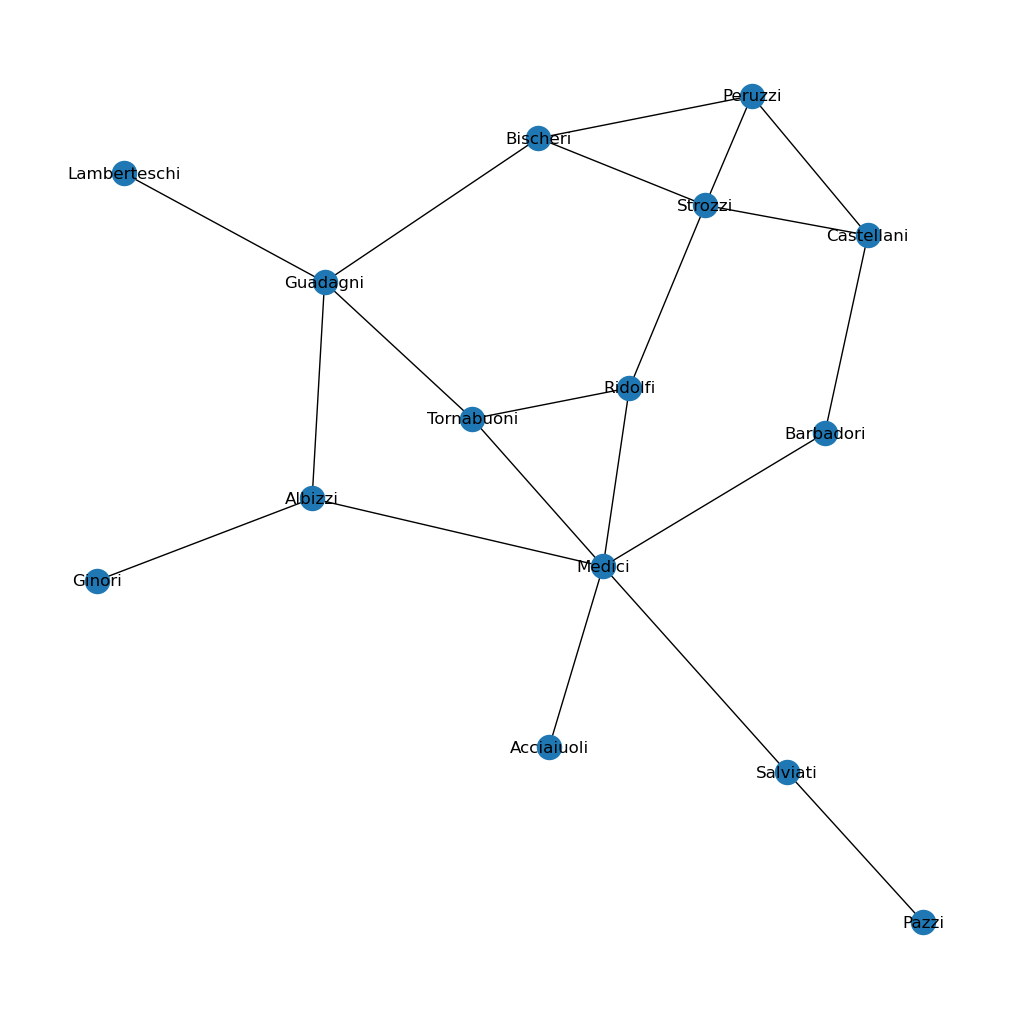

In [8]:
# plot network
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
for node in medici_names:
	for neighbor in medici_names[node]:
		G.add_edge(node, neighbor)

plt.figure(figsize=(10,10))
nx.draw(G, with_labels=True)
plt.show()

/tmp/ipykernel_54006/3605592551.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=centrality,y='Harmonic Centrality', x='Family', palette=['grey' if 'Medici' not in family else 'green' for family in centrality['Family']], ax=ax)


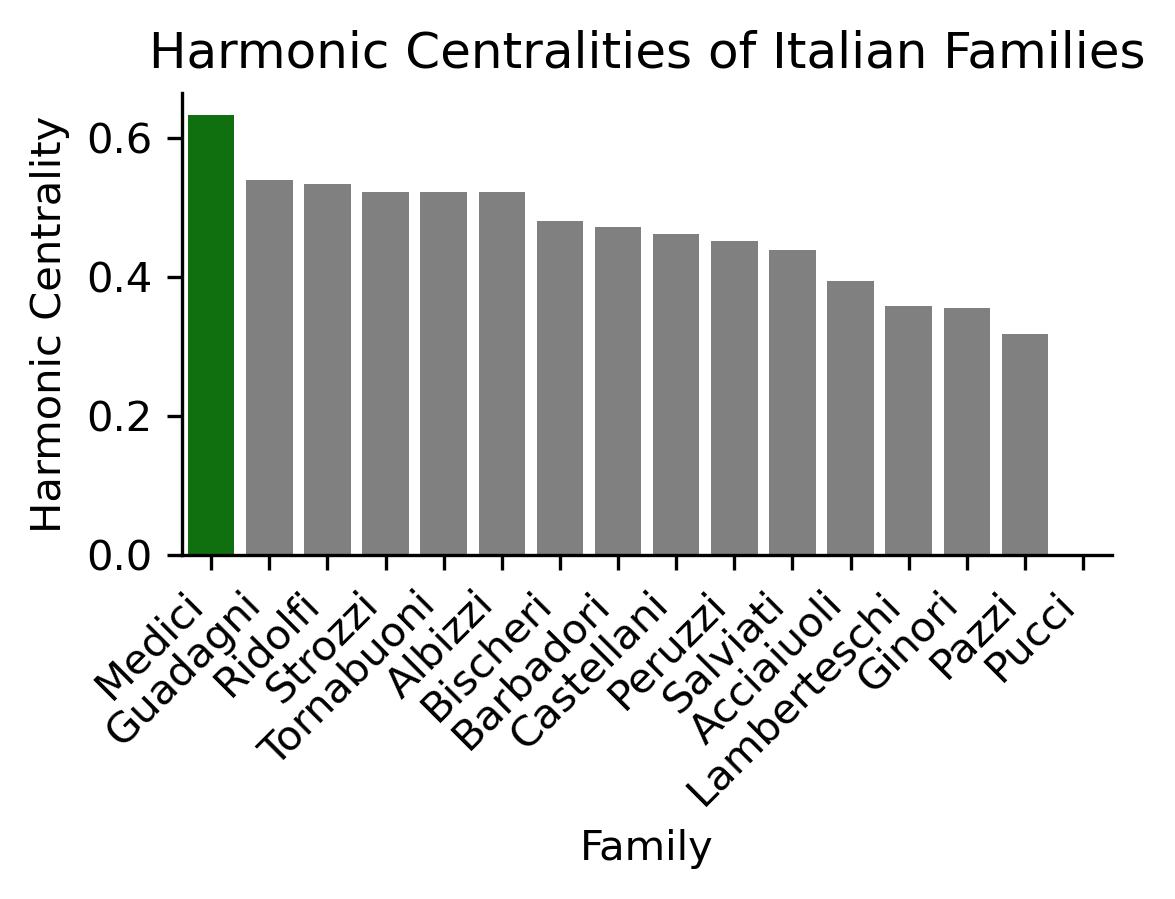

In [9]:
# Plot the harmonic centralities in order of highest to lowest as bar plot, color Medici green and the rest grey
fig,ax = plt.subplots(figsize=(4,2), dpi=300)

# sort the nodes by centrality (make sure to preserve name:value pairs)
centrality = harmonic_centrality(medici_names)
# convert to pandas
centrality = pd.DataFrame(centrality.items(), columns=['Family','Harmonic Centrality']).sort_values('Harmonic Centrality',ascending=False)

sns.barplot(data=centrality,y='Harmonic Centrality', x='Family', palette=['grey' if 'Medici' not in family else 'green' for family in centrality['Family']], ax=ax)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Family')
ax.set_ylabel('Harmonic Centrality')
ax.set_title('Harmonic Centralities of Italian Families')

sns.despine()
plt.show()

In [10]:
# to what degree can each family's structure be explained as purely a function of the network's degree sequence \vec{k}?

# Run 1000 configuration models of the graph to get a null distribution of harmonic centralities
# Then compare the empirical harmonic centralities to the null distribution

null_centralities = pd.DataFrame(columns=medici_names.keys())

m = sum(len(neighbors) for neighbors in medici_names.values()) // 2

for i in tqdm(range(1000)):
	# make a copy of the adjacency list
	medici_copy = deepcopy(medici_names)
	# perform a full randomization
	medici_copy = double_edge_swap(medici_copy, 20 * m)
	# calculate the harmonic centralities
	centrality = harmonic_centrality(medici_copy)
	# write to the dataframe
	null_centralities.loc[i] = centrality
	
null_centralities

  0%|          | 2/1000 [00:00<01:03, 15.68it/s]

100%|██████████| 1000/1000 [00:38<00:00, 25.67it/s]


,Acciaiuoli,Albizzi,Barbadori,Bischeri,Castellani,Ginori,Guadagni,Lamberteschi,Medici,Pazzi,Peruzzi,Pucci,Ridolfi,Salviati,Strozzi,Tornabuoni
0,0.366667,0.494444,0.450000,0.494444,0.483333,0.372222,0.555556,0.335556,0.655556,0.366667,0.488889,0.0,0.494444,0.396667,0.566667,0.494444
1,0.258889,0.438889,0.346667,0.450000,0.407778,0.313333,0.494444,0.066667,0.552222,0.066667,0.430000,0.0,0.441111,0.394444,0.511111,0.461111
2,0.388889,0.505556,0.413333,0.483333,0.452222,0.352222,0.577778,0.388889,0.622222,0.325556,0.500000,0.0,0.466667,0.402222,0.527778,0.466667
3,0.345556,0.451111,0.438889,0.505556,0.505556,0.345556,0.505556,0.340000,0.633333,0.317778,0.511111,0.0,0.461111,0.384444,0.516667,0.511111
4,0.066667,0.455556,0.368889,0.455556,0.477778,0.324444,0.494444,0.315556,0.588889,0.066667,0.466667,0.0,0.466667,0.394444,0.477778,0.422222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.366667,0.477778,0.413333,0.516667,0.505556,0.332222,0.555556,0.400000,0.644444,0.346667,0.494444,0.0,0.505556,0.411111,0.555556,0.505556
996,0.357778,0.480000,0.435556,0.446667,0.480000,0.314444,0.538889,0.346667,0.627778,0.332222,0.477778,0.0,0.505556,0.416667,0.566667,0.522222
997,0.294444,0.488889,0.444444,0.476667,0.476667,0.330000,0.555556,0.294444,0.622222,0.346667,0.410000,0.0,0.488889,0.415556,0.521111,0.476667
998,0.328889,0.511111,0.477778,0.522222,0.485556,0.363333,0.561111,0.405556,0.655556,0.368889,0.472222,0.0,0.533333,0.450000,0.550000,0.494444


In [11]:
centrality

{'Acciaiuoli': 0.35777777777777775,
 'Albizzi': 0.44666666666666666,
 'Barbadori': 0.44999999999999996,
 'Bischeri': 0.47222222222222215,
 'Castellani': 0.5222222222222223,
 'Ginori': 0.3233333333333333,
 'Guadagni': 0.5388888888888889,
 'Lamberteschi': 0.3411111111111111,
 'Medici': 0.6555555555555556,
 'Pazzi': 0.3555555555555555,
 'Peruzzi': 0.49444444444444435,
 'Pucci': 0.0,
 'Ridolfi': 0.49444444444444435,
 'Salviati': 0.4444444444444444,
 'Strozzi': 0.5555555555555555,
 'Tornabuoni': 0.4611111111111111}

In [12]:
differences = pd.DataFrame(columns=medici_names.keys())

for family in medici_names:
	# calculate the difference between the empirical harmonic centrality and the mean of the null distribution
	differences[family] = null_centralities[family] - centrality[family]

# reorder the columns by mean
differences = differences[differences.mean().sort_values(ascending=False).index]

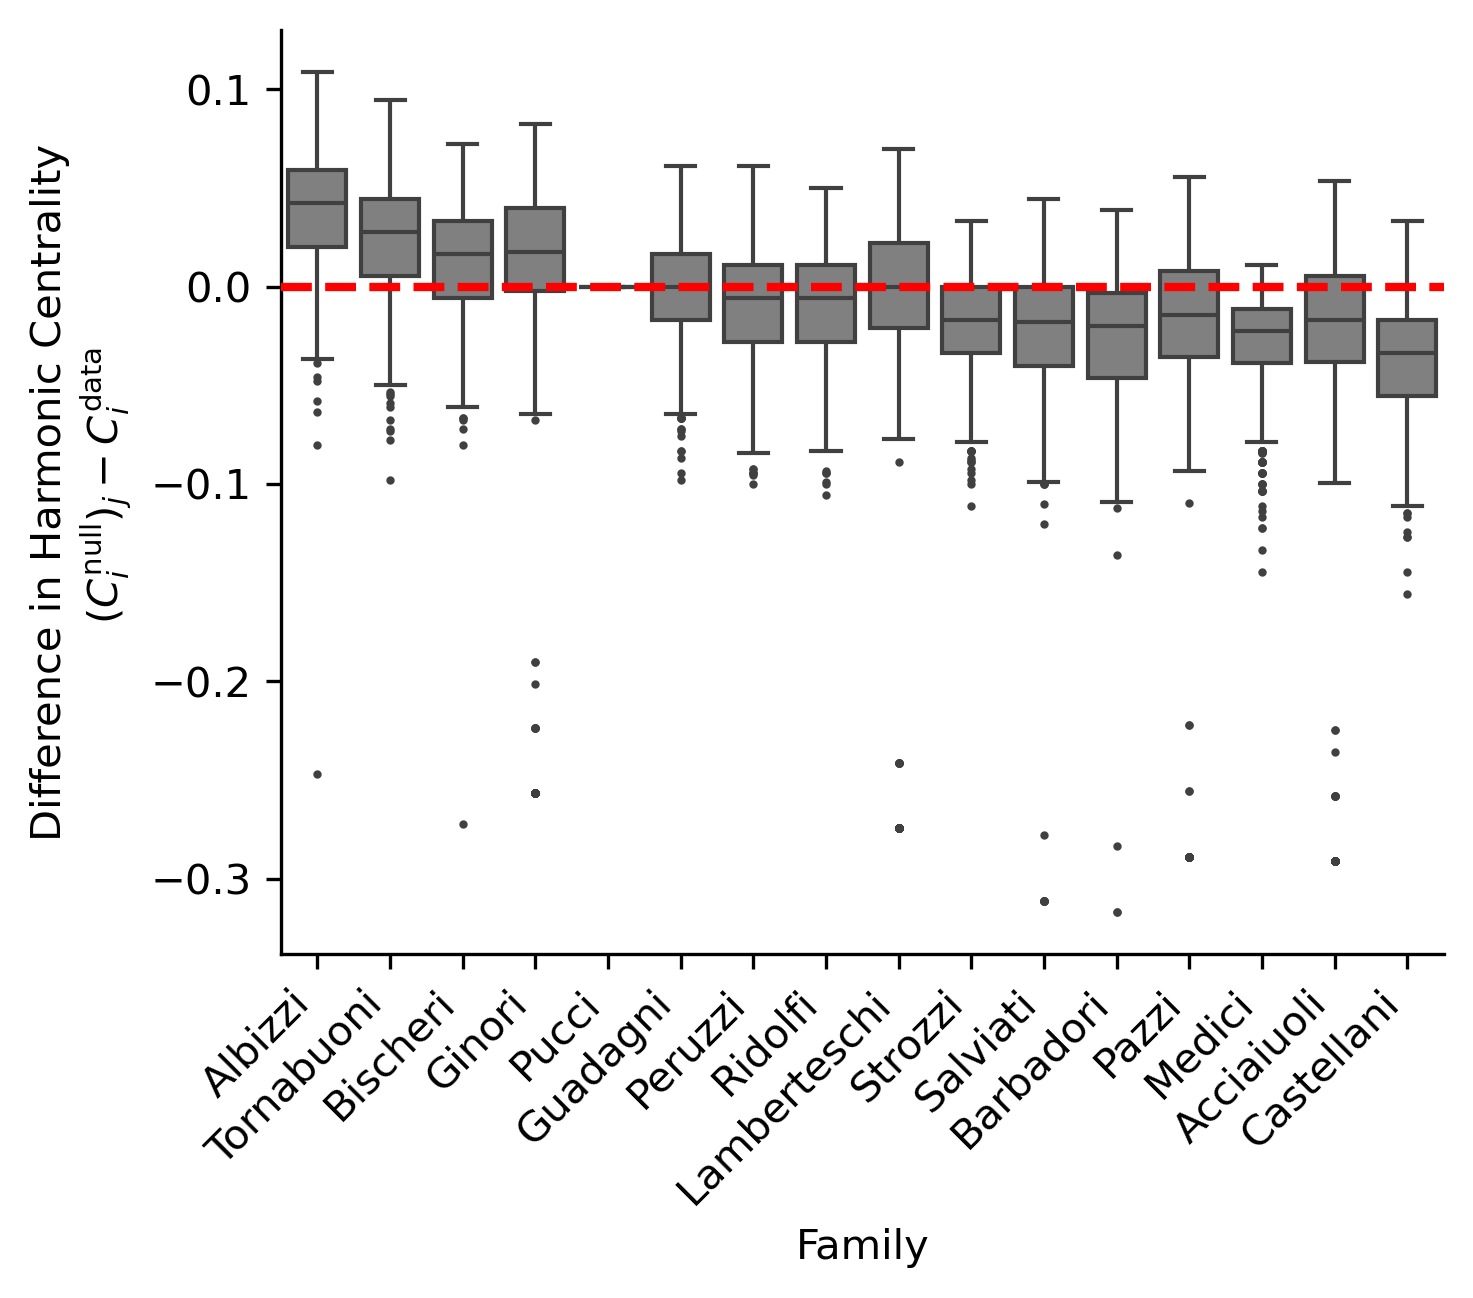

In [13]:
fig,ax = plt.subplots(figsize=(5,4),dpi=300)
sns.boxplot(data=differences, ax=ax, color='grey', fliersize=1)
ax.axhline(0, color='red', linestyle='--', label='Empirical Value',linewidth=2,zorder=999)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Family')
ax.set_ylabel('Difference in Harmonic Centrality\n $(C_i^{\\text{null}})_j - C_i^{\\text{data}}$')
sns.despine()

In [14]:
# The same thing, but this time the null model uses the stub-matching algorithm to make stub-labeled loopy multigraphs, which are then simplified by removing self-loops and collapsing multiedges.

def stub_matching_null(adj):
	# molloy-reed
	stubs = []
	for node in adj:
		stubs.extend([node] * len(adj[node]))
	# shuffle the stubs
	random.shuffle(stubs)
	# make a copy of the adjacency list
	adj_copy = {k: list(v) for k, v in adj.items()}
	# iterate over the nodes
	for node in adj:
		# iterate over the neighbors
		for neighbor in adj[node]:
			# find a stub that doesn't match the current node
			stub = random.choice(stubs)
			# while True:
			# 	# get a stub
			# 	stub = random.choice(stubs)
			# 	# if the stub doesn't match the current node, we're done
			# 	if stub != node:
			# 		break
			# remove the stub from the list
			stubs.remove(stub)
			# add the edge
			adj_copy[node].append(stub)
			adj_copy[stub].append(node)
	# remove self-loops
	for node in adj_copy:
		adj_copy[node] = [neighbor for neighbor in adj_copy[node] if neighbor != node]
	# collapse multiedges
	for node in adj_copy:
		adj_copy[node] = list(set(adj_copy[node]))

	return adj_copy


stub_null_centralities = pd.DataFrame(columns=medici_names.keys())

for i in tqdm(range(1000)):
	# make a copy of the adjacency list
	medici_copy = deepcopy(medici_names)
	# stub-matching
	medici_copy = stub_matching_null(medici_copy)
	# calculate the harmonic centralities
	centrality = harmonic_centrality(medici_copy)
	# write to the dataframe
	stub_null_centralities.loc[i] = centrality

stub_null_centralities

100%|██████████| 1000/1000 [00:34<00:00, 29.18it/s]


,Acciaiuoli,Albizzi,Barbadori,Bischeri,Castellani,Ginori,Guadagni,Lamberteschi,Medici,Pazzi,Peruzzi,Pucci,Ridolfi,Salviati,Strozzi,Tornabuoni
0,0.511111,0.733333,0.655556,0.633333,0.700000,0.488889,0.800000,0.566667,0.766667,0.555556,0.655556,0.0,0.622222,0.666667,0.733333,0.733333
1,0.566667,0.766667,0.666667,0.633333,0.700000,0.555556,0.766667,0.555556,0.833333,0.555556,0.666667,0.0,0.700000,0.666667,0.600000,0.633333
2,0.500000,0.666667,0.555556,0.600000,0.666667,0.533333,0.733333,0.522222,0.800000,0.533333,0.566667,0.0,0.633333,0.588889,0.722222,0.666667
3,0.522222,0.733333,0.600000,0.588889,0.666667,0.566667,0.833333,0.533333,0.800000,0.566667,0.700000,0.0,0.633333,0.633333,0.733333,0.666667
4,0.555556,0.588889,0.533333,0.622222,0.622222,0.383333,0.688889,0.500000,0.766667,0.472222,0.688889,0.0,0.644444,0.577778,0.700000,0.622222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.566667,0.700000,0.588889,0.700000,0.700000,0.555556,0.800000,0.566667,0.900000,0.566667,0.666667,0.0,0.700000,0.600000,0.766667,0.733333
996,0.500000,0.633333,0.544444,0.600000,0.700000,0.477778,0.733333,0.544444,0.800000,0.555556,0.688889,0.0,0.655556,0.622222,0.722222,0.666667
997,0.511111,0.666667,0.666667,0.622222,0.700000,0.466667,0.766667,0.544444,0.833333,0.544444,0.655556,0.0,0.655556,0.655556,0.766667,0.700000
998,0.555556,0.633333,0.555556,0.555556,0.700000,0.566667,0.733333,0.555556,0.866667,0.533333,0.666667,0.0,0.666667,0.588889,0.733333,0.666667


In [15]:
differences_stubs = pd.DataFrame(columns=medici_names.keys())

for family in medici_names:
	# calculate the difference between the empirical harmonic centrality and the mean of the null distribution
	differences_stubs[family] = stub_null_centralities[family] - centrality[family]

# reorder the columns by mean
differences_stubs = differences_stubs[differences_stubs.mean().sort_values(ascending=False).index]

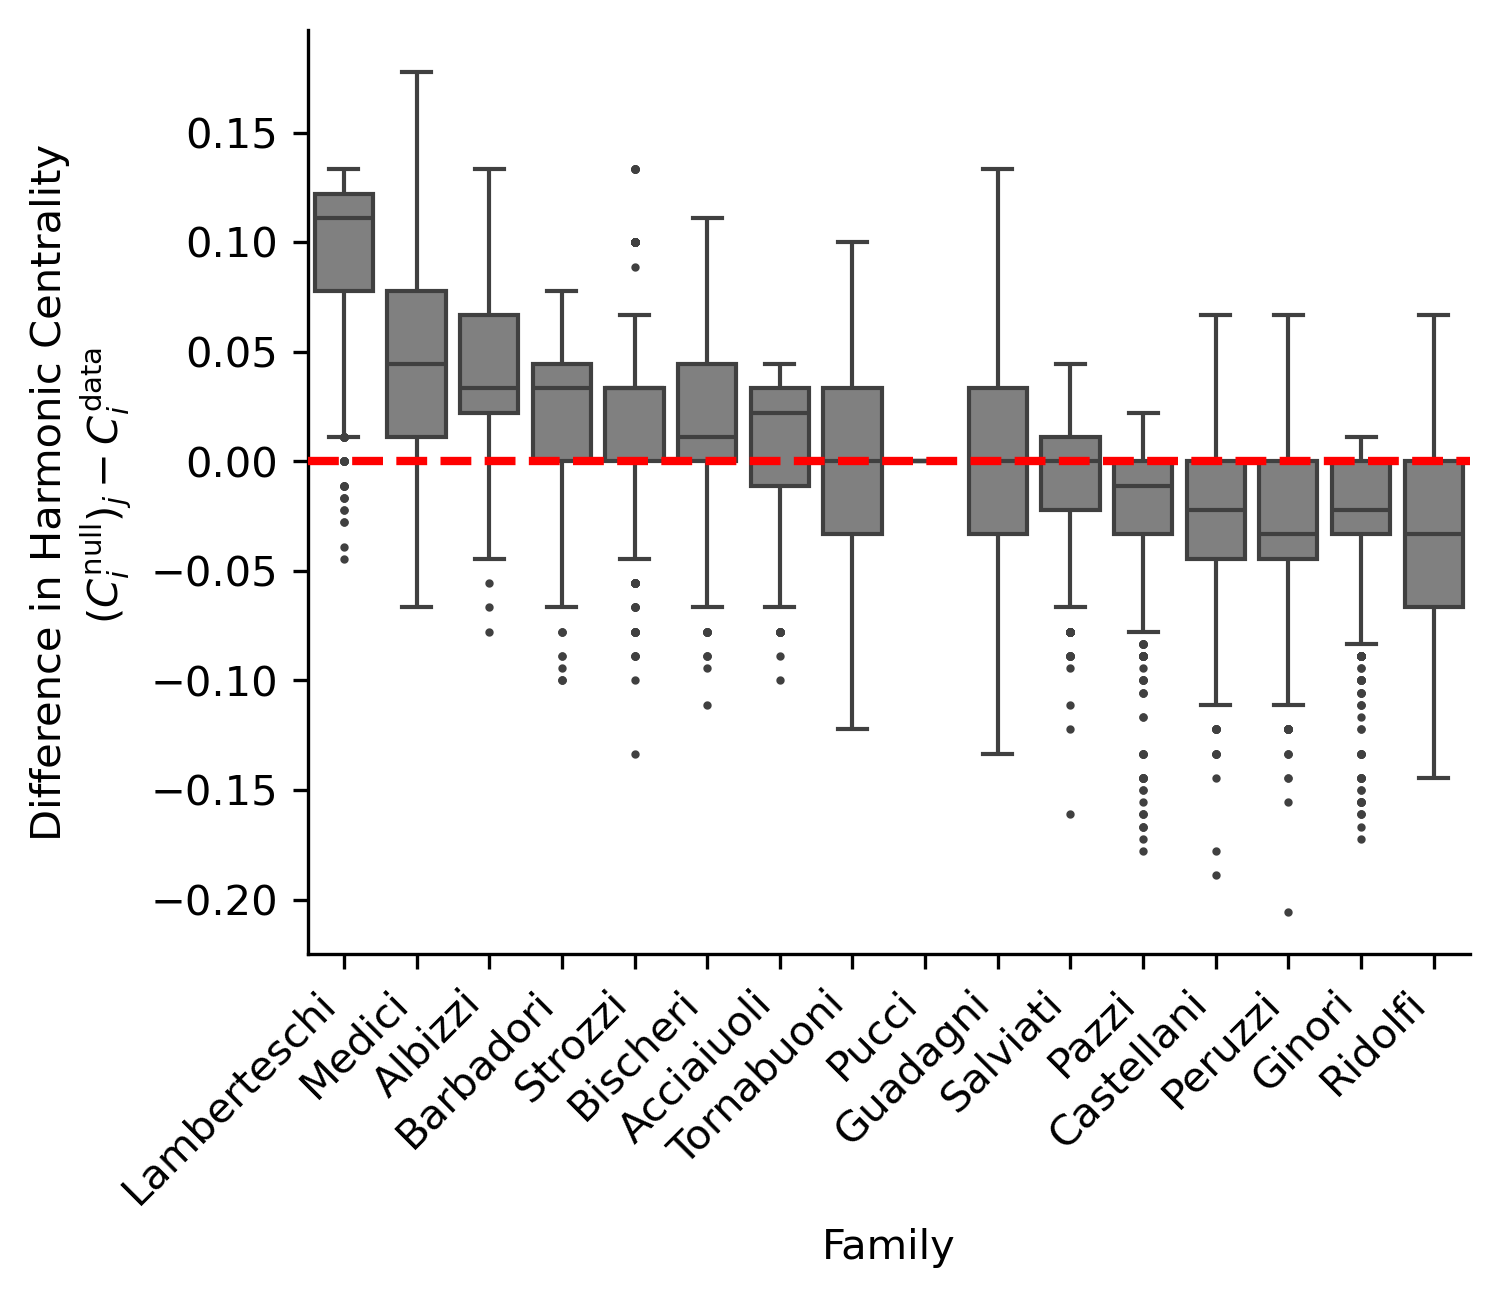

In [54]:
fig,ax = plt.subplots(figsize=(5,4),dpi=300)
sns.boxplot(data=differences_stubs, ax=ax, color='grey', fliersize=1)
ax.axhline(0, color='red', linestyle='--', label='Empirical Value',linewidth=2,zorder=999)
plt.xticks(rotation=45, ha='right')
ax.set_xlabel('Family')
ax.set_ylabel('Difference in Harmonic Centrality\n $(C_i^{\\text{null}})_j - C_i^{\\text{data}}$')
sns.despine()

### Problem 6

In [ ]:
# make a watts-strogatz graph and rewire edges, sampling the distribution of betweenness centrality values at 50 points
import networkx as nx
import numpy as np

def watts_strogatz(n, k, p):
    if k % 2 != 0:
        raise ValueError("k must be even for a proper ring lattice.")

    # Create a k-regular ring lattice
    graph = {i: [] for i in range(n)}
    for i in range(n):
        for j in range(1, k//2 + 1):  # Only add forward edges to avoid duplicates
            neighbor = (i + j) % n
            graph[i].append(neighbor)
            graph[neighbor].append(i)

    r = 0  # Counter for rewired edges

    # Rewire only the "forward" edges to avoid double counting
    for node in range(n):
        for neighbor in list(graph[node]):  # Copy list to avoid modification issues
            if neighbor > node and np.random.rand() < p:  # Process only if neighbor > node to avoid duplicates
                possible_nodes = set(range(n)) - set(graph[node]) - {node}
                if possible_nodes:
                    new_neighbor = np.random.choice(list(possible_nodes))

                    # Remove old edge
                    graph[node].remove(neighbor)
                    graph[neighbor].remove(node)

                    # Add new edge
                    graph[node].append(new_neighbor)
                    graph[new_neighbor].append(node)

                    r += 1  # Increment rewiring counter

    return graph, r




ws_df = pd.DataFrame(columns=['p','r','betweenness'])
n_exp = 1000
n = 100

for i in tqdm(range(n_exp)):
	# make a watts-strogatz graph with p = i/n_exp
	graph,r = watts_strogatz(n, 4, i/n_exp)
	# convert adjacency list to networkx graph for betweenness
	G = nx.Graph(graph)
	betweenness = nx.betweenness_centrality(G,k=n)

	ws_df.loc[i] = [i/n_exp,r,np.mean(list(betweenness.values()))]

ws_df


  0%|          | 0/1000 [00:00<?, ?it/s]

 55%|█████▍    | 546/1000 [00:22<00:20, 22.38it/s]

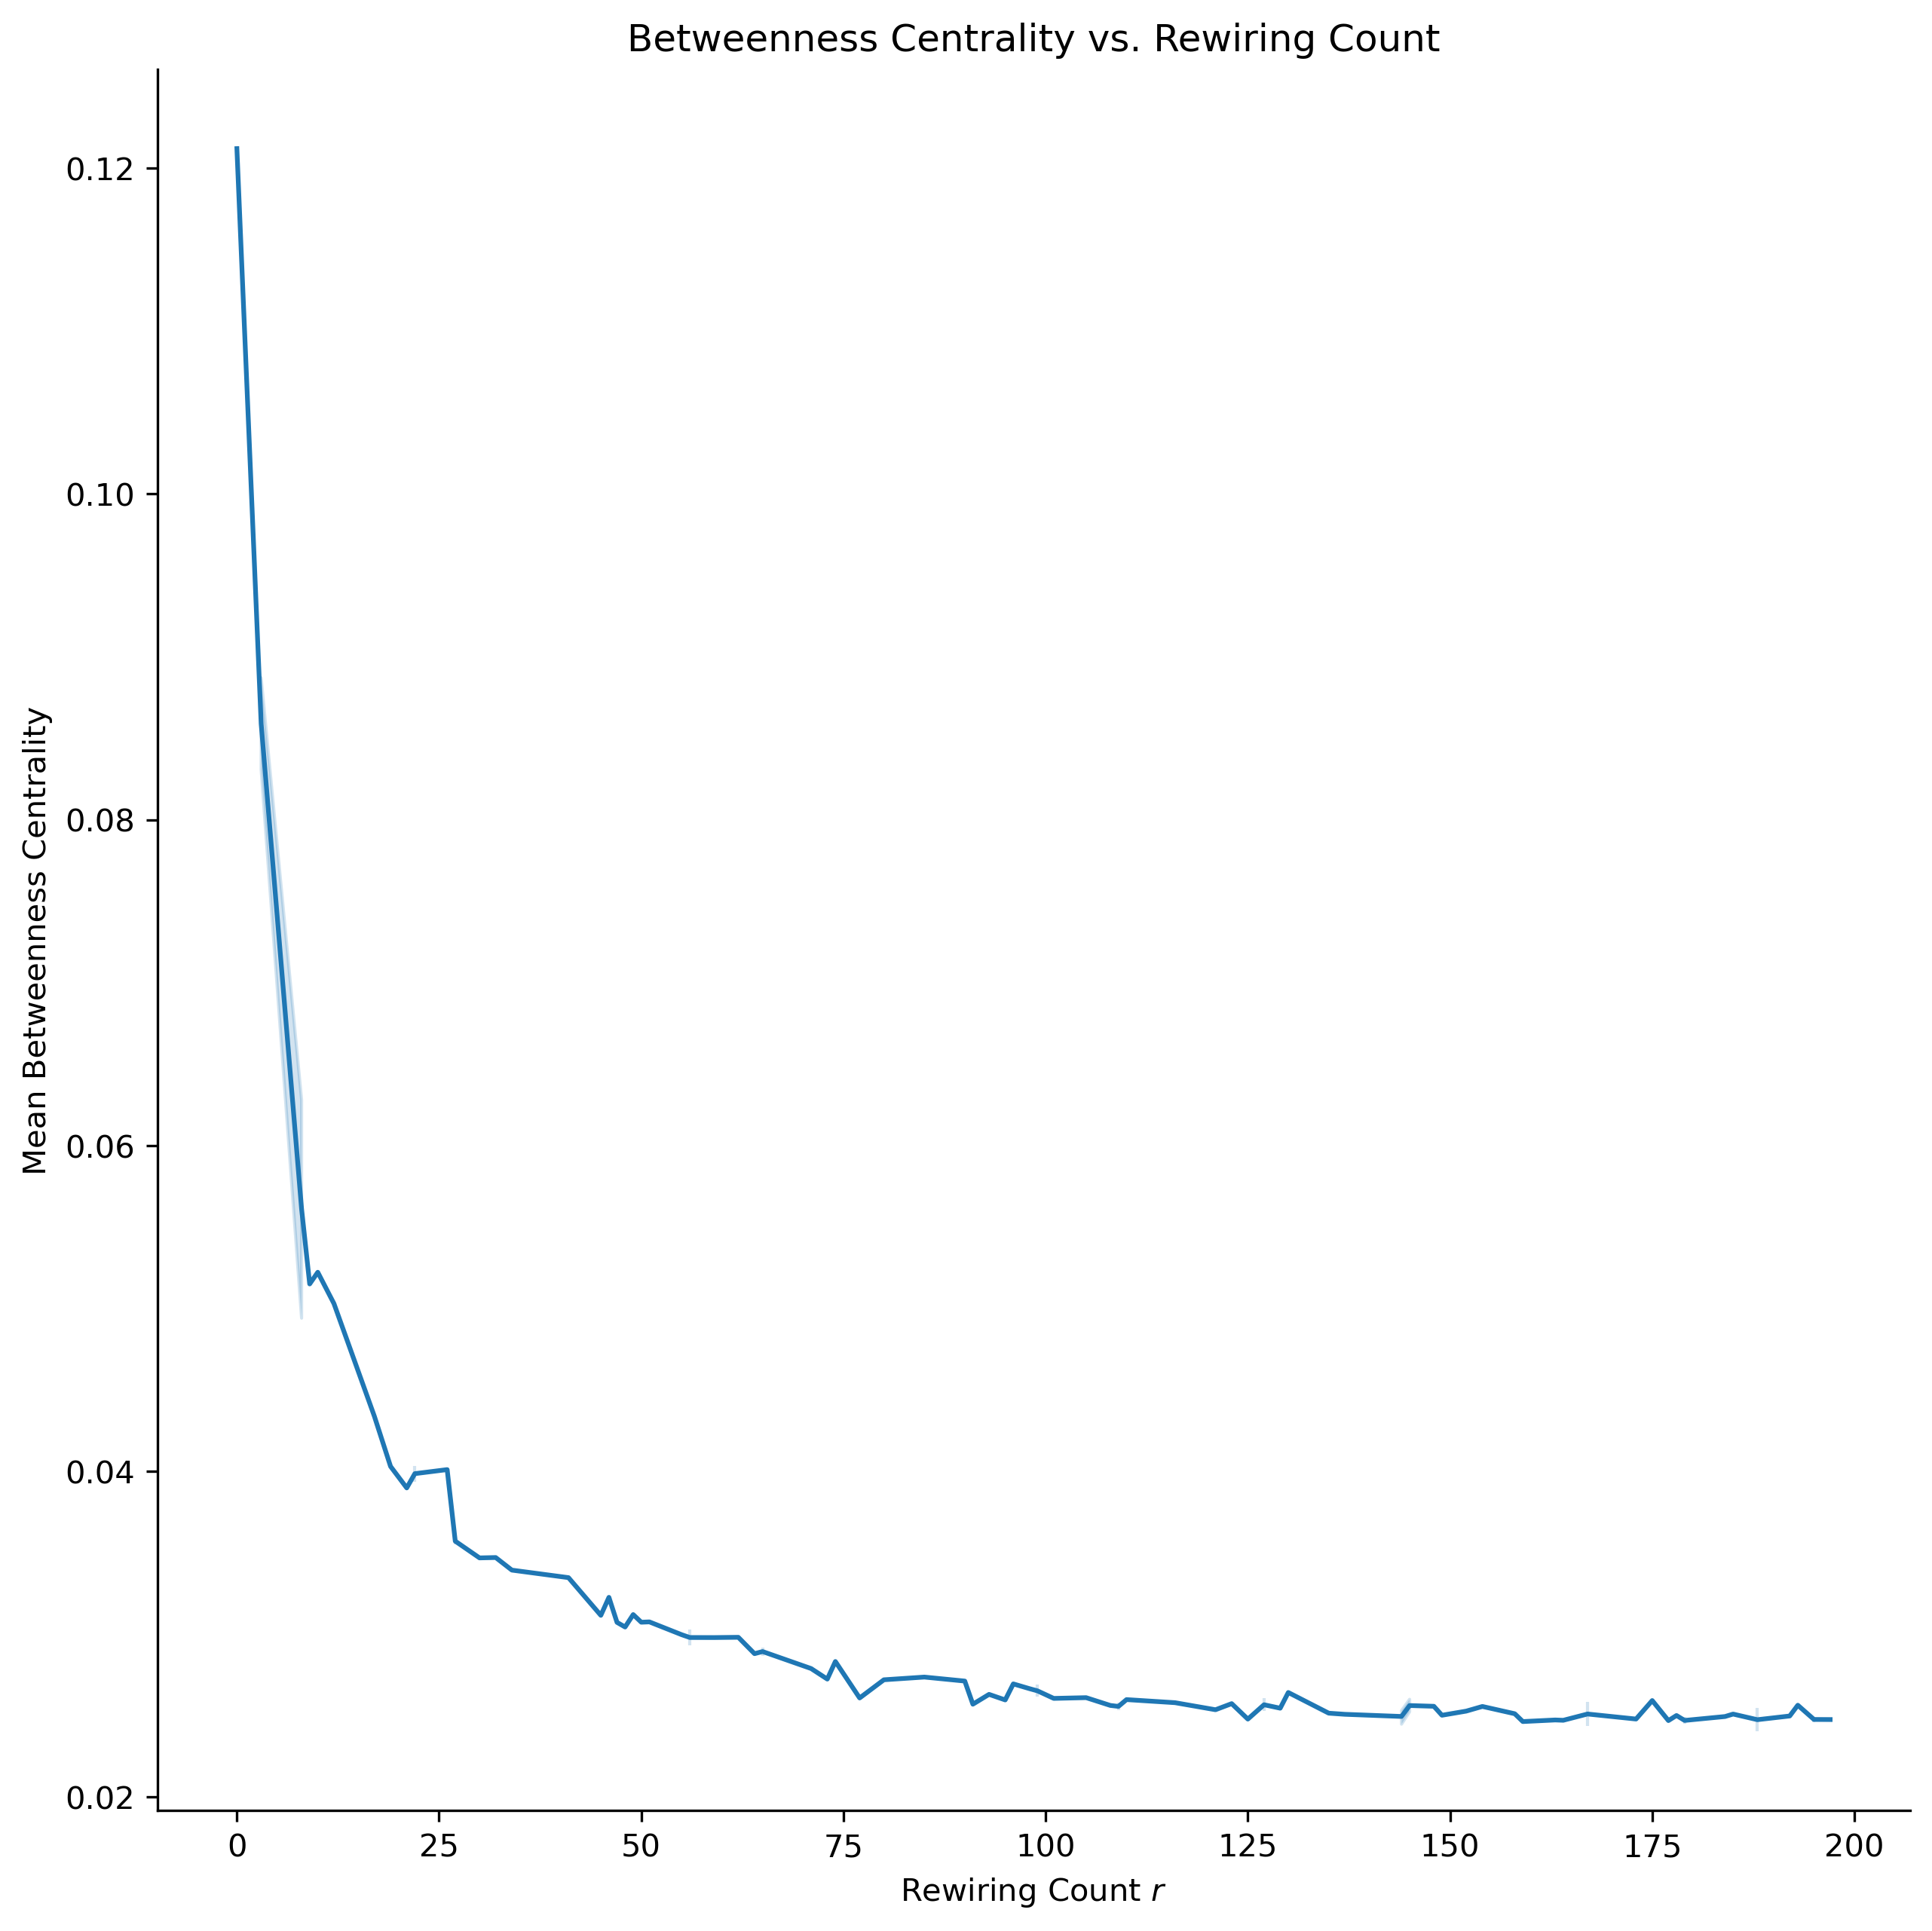

In [ ]:
# plot the betweenness centrality against the rewiring count r
fig,ax = plt.subplots(figsize=(5,4),dpi=300)
sns.lineplot(data=ws_df,x='r',y='betweenness',ax=ax)
ax.set_xlabel('Rewiring Count $r$')
ax.set_ylabel('Mean Betweenness Centrality')
ax.set_title('Betweenness Centrality vs. Rewiring Count')
sns.despine()
plt.show()